In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, TimeSeriesSplit

from sklearn.preprocessing import StandardScaler, Normalizer

import statsmodels.api as sm

from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

from sklearn.metrics import r2_score

In [200]:
df = pd.read_csv('train_data_200k.csv')

In [201]:
df

,Unnamed: 0,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,...,tag44,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
0,2016-08-18 00:00:00,15.78042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30402,60.01311,-0.001269,0.018163,-0.000183,0.000671,0.000956,0.000858,0.000992,NaN,19.267140,22.330680,15.60123,80.97660,22.335270,33.871220,24.003390,57.063840,44.543090,23.807960,27.632200,47.279970,23.96099,23.945220,26.39192,47.871580,37.12356,36.37045,NaN,67.60985,...,NaN,NaN,NaN,183.3191,206.6534,69.99840,NaN,NaN,50.50632,46.30415,61.20765,72.77773,25.30402,60.01311,2.373747,0.677581,2.775156,1.769055,2.766034,2.794747,33.42513,34.27024,39.65590,44.48986,50.34106,37.34515,53.65030,50.70506,61.08673,72.76518,53.02723,66.30531,55.10297,73.65612,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-08-18 00:01:00,15.80157,NaN,NaN,NaN,NaN,NaN,53.06440,NaN,NaN,25.30464,60.01566,-0.001289,0.018208,-0.000210,0.000670,0.000947,0.000857,0.001003,25.31277,19.262050,22.359790,15.61021,80.98914,22.336960,33.895640,23.992640,57.050220,44.493670,23.815030,27.634960,47.279940,23.97050,23.937770,26.40619,47.863340,37.09820,36.26917,NaN,NaN,...,NaN,NaN,NaN,185.1547,205.3378,69.98409,NaN,NaN,50.49541,46.20826,61.20348,72.76062,25.30464,60.01566,2.373543,0.677852,2.775152,1.769295,2.766190,2.794963,33.41073,34.25732,39.70995,44.46941,50.31259,37.34732,53.65897,50.60955,61.09685,72.76947,53.05109,66.30098,55.11534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-08-18 00:02:00,15.68913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30486,60.01267,-0.001310,0.018185,-0.000146,0.000663,0.000957,0.000855,0.001004,NaN,19.267930,22.385000,15.59624,80.94573,22.337680,33.916510,23.987890,57.047450,44.525990,23.812060,27.636830,47.246750,23.96895,23.920400,26.36558,47.877790,37.10657,36.28939,91.98822,67.92857,...,NaN,NaN,NaN,185.7857,206.4609,70.04832,NaN,NaN,50.49607,46.24781,61.20309,72.76160,25.30486,60.01267,2.373388,0.677734,2.775619,1.768982,2.766650,2.795123,33.41452,34.23959,39.74942,44.45711,50.31557,37.32831,53.66189,50.60200,61.05627,72.75539,53.06495,66.30359,55.09395,NaN,NaN,55.07365,NaN,NaN,NaN,NaN
3,2016-08-18 00:03:00,15.75101,NaN,20.26209,NaN,NaN,NaN,52.95166,NaN,NaN,25.30544,60.01596,-0.000885,0.018180,-0.000192,0.000672,0.000949,0.000864,0.001003,NaN,19.241530,22.342160,15.60701,80.93867,22.334340,33.982460,23.987950,57.051030,44.515840,23.808590,27.627370,47.260190,23.94341,23.911530,26.39959,47.913070,37.14546,36.27222,NaN,NaN,...,NaN,NaN,NaN,182.6789,207.5279,69.95206,37.13296,NaN,50.51320,46.13975,61.28067,72.77470,25.30544,60.01596,2.385501,0.678970,2.775364,1.769024,2.766515,2.795122,33.40705,34.23381,39.79846,44.47630,50.28574,37.30737,53.67104,50.68343,61.00186,72.77387,53.06760,66.28421,55.12513,NaN,92.46913,NaN,NaN,NaN,NaN,NaN
4,2016-08-18 00:04:00,15.57773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.30540,60.01478,-0.001005,0.018167,-0.000113,0.000678,0.000955,0.000865,0.001013,NaN,19.251760,22.336900,15.60543,80.97723,22.335300,34.050270,23.983890,57.059970,44.517750,23.766360,27.642370,47.208090,23.93508,23.902700,26.37914,47.931060,37.13568,36.26667,NaN,NaN,...,NaN,NaN,NaN,186.6251,NaN,69.99007,NaN,NaN,50.50373,46.33209,61.28010,72.72731,25.30540,60.01478,2.385056,0.678937,2.775762,1.769598,2.766815,2.795541,33.37688,34.22705,39.81411,44.48069,50.23417,37.30698,53.58812,50.64983,61.04366,72.72121,53.09679,66.26472,55.15526,73.67016,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [202]:
df.describe()

,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,tag22,tag23,tag24,tag25,tag26,tag27,tag28,tag29,tag30,tag31,tag32,tag33,tag34,tag35,tag36,tag37,tag38,tag39,tag40,...,tag44,tag45,tag46,tag47,tag48,tag49,tag50,tag51,tag52,tag53,tag54,tag55,tag56,tag57,tag58,tag59,tag60,tag61,tag62,tag63,tag64,tag65,tag66,tag67,tag68,tag69,tag70,tag71,tag72,tag73,tag74,tag75,tag76,tag77,tag78,tag79,target1,target2,target3,target4
count,1.999340e+05,109370.000000,109456.000000,85.000000,9736.000000,373.000000,88122.000000,16777.000000,407.000000,199837.000000,199867.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,199875.000000,100168.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,39220.000000,38048.000000,1.583080e+05,152970.000000,15578.000000,...,1.117250e+05,1.138000e+05,98410.0,1.998670e+05,132355.000000,199866.000000,78120.000000,14722.000000,101792.000000,84189.000000,59443.000000,199867.000000,199837.000000,199867.000000,199837.000000,199119.000000,199875.000000,35810.000000,36726.000000,199875.000000,199867.000000,199867.000000,199867.000000,199867.000000,199867.000000,37652.000000,199867.000000,199867.000000,199867.000000,35087.000000,199867.000000,199867.000000,199867.000000,48803.000000,48673.000000,48558.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,1.471747e+01,0.003483,12.696579,9.101270,31.654650,68.328355,47.680708,46.703799,71.668521,23.584873,50.128928,-0.000334,0.009145,-0.001012,0.000952,0.000641,0.000594,0.001458,20.305728,11.696598,13.797841,11.759747,81.016135,19.222866,8.782267,10.878145,20.160856,17.093377,25.379681,26.202377,20.609791,5.374740,19.468993,10.680114,23.355227,35.503725,34.075806,7.990204e+01,59.421573,40.916190,...,1.761049e+01,1.316814e+00,0.0,1.848092e+02,245.337823,69.513164,43.837855,45.891781,46.728568,46.626250,59.817989,72.660003,23.584873,50.128928,2.415533,0.716383,2.769036,1.769548,2.763237,2.793360,20.816438,26.055005,28.467759,43.801585,38.095371,35.714963,43.459269,50.051799,56.016110,72.578699,41.898820,66.520646,53.966135,75.458923,94.800765,55.872240,0.001156,0.049836,0.942428,0.006580
std,1.873427e+00,0.017229,4.285856,9.667475,5.039073,13.580792,4.506643,3.940905,0.606023,4.877921,16.948128,0.002746,0.006391,0.000964,0.000167,0.000156,0.000138,0.000478,4.028258,6.351744,6.973005,5.400680,0.562162,13.288055,19.251651,9.765605,29.312477,23.205521,15.660261,11.451187,25.272481,14.370803,9.534630,15.769529,21.636223,3.704882,4.235066,5.119445e+00,3.839873,2.699708,...,3.041737e+00,9.415702e-01,0.0,6.731712e+00,18.389717,4.449915,3.705196,3.696100,3.468820,2.981598,3.227836,0.214569,4.877921,16.948128,0.186903,0.179985,0.036395,0.003708,0.008499,0.007465,11.133341,3.790688,7.818537,1.117651,8.392762,3.534464,7.486956,1.536693,4.041327,0.235175,7.772574,0.392989,1.512331,0.872953,2.888815,1.450305,0.000085,0.003685,0.003936,0.001442
min,2.215690e-08,-0.005142,0.008831,-3.354573,15.898870,10.271640,22.730830,24.820300,69.825200,8.848302,-0.050376,-0.030081,-0.003332,-0.002694,0.000252,0.000161,0.000170,0.000683,0.000000,-10.558860,-9.543885,-19.495170,68.816150,-7.698016,-34.570690,-14.961360,-34.654410,-30.909190,-4.582263,2.232100,-29.993390,-37.930990,-6.355927,-34.072190,-21.258420,18.954950,15.042280,6.259399e-07,0.020922,20.059580,...,2.313189e-25,2.303353e-25,0.0,6.076754e-19,0.000218,19.210710,22.781390,28.341410,24.284860,27.575620,37.753350,67.914190,8.848302,-0.050376,1.947665,-0.000511,0.000097,1.703969,2.574159,2.599954,0.000000,15.118610,-4.038994,33.356780,18.640790,18.862820,23.278410,40.573780,43.124100,67.901700,23.078610,62.552550,44.860980,71.780270,90.015210,46.590670,0.000826,0.035611,0.912861,0.002595
25%,1.359252e+01,0.001326,8.111923,4.375712,28.884520,71.9185

Drop explanatory variables that contains NaN

In [203]:
df = df.dropna(subset = ['target1', 'target2', 'target3','target4'])

Explore NaN distribution

(array([ 8.,  6.,  4.,  1.,  3.,  6.,  1.,  2.,  0., 49.]),
 array([8.500000e+01, 2.007560e+04, 4.006620e+04, 6.005680e+04,
        8.004740e+04, 1.000380e+05, 1.200286e+05, 1.400192e+05,
        1.600098e+05, 1.800004e+05, 1.999910e+05]),
 <a list of 10 Patch objects>)

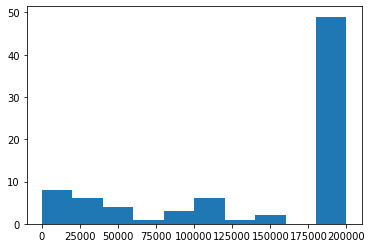

In [204]:
plt.hist(df.loc[:, df.columns[:-4]].count())

Explore feature importances with XGBoost <br>

<i> Not sure about how correct count feature importance with multiple regressors, so suppose it is just mean over all regressors

In [205]:
def top_10_feature_importances():
    
    feature_importances = []
    scores = []
    preds = []
    top10_mean_over_all_regs = np.zeros((df.shape[1] - 5))
    num = 50000
    X_train, X_test =df.iloc[:-num, 1:-4].values, df.iloc[-num:, 1:-4].values
    for i in range(1,5):
        y_train, y_test = df.iloc[:-num, -i].values, df.iloc[-num:, -i].values
        regressor = xgb.XGBRegressor(tree_method = 'gpu_hist')
        regressor.fit(X_train, y_train)
        
        feat_imp = dict(zip(df.columns[1:-4], regressor.feature_importances_))
        top10 =  dict(sorted(feat_imp.items(), key = lambda x: x[1], reverse = True)[:10])
        feature_importances.append(top10)
        scores.append(regressor.score(X_test, y_test))
        preds.append(regressor.predict(X_test))
        
        top10_mean_over_all_regs += regressor.feature_importances_
        
    top10_mean_over_all_regs = dict(zip(df.columns[1:-4], top10_mean_over_all_regs / 4))
    top10_mean_over_all_regs = dict(sorted(top10_mean_over_all_regs.items(), key = lambda x: x[1], reverse = True)[:10])
    
        
    
    return scores, feature_importances, top10_mean_over_all_regs, preds
    
    
        

In [206]:
scores, feature_importances, top10_mean_over_all_regs, preds = top_10_feature_importances()

[21:32:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:32:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:32:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:32:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Top 10 features over all features

<BarContainer object of 10 artists>

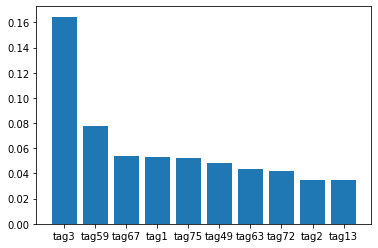

In [207]:
plt.figure()
plt.bar(top10_mean_over_all_regs.keys(), top10_mean_over_all_regs.values())

Top 10 correspond each regressor

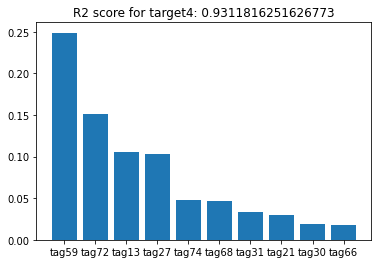

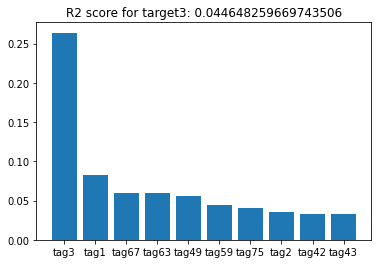

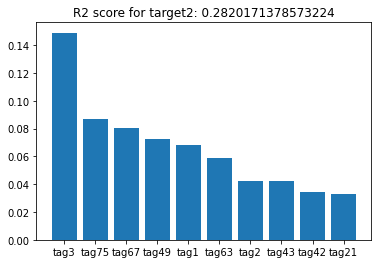

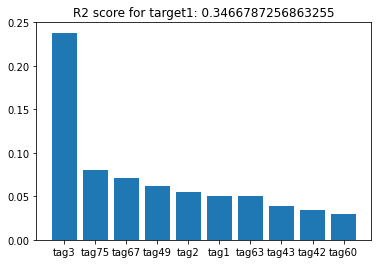

In [208]:
for i in range(4):
    plt.figure()
    plt.bar(feature_importances[i].keys(), feature_importances[i].values())
    plt.title('R2 score for {}: {}'.format(df.columns[-(i+1)], scores[i]))

Predict \ true graphics

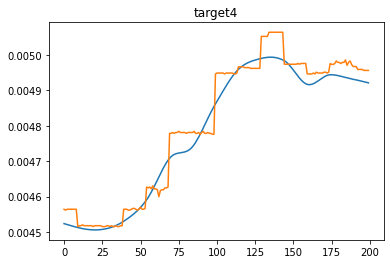

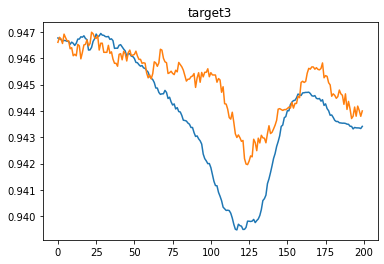

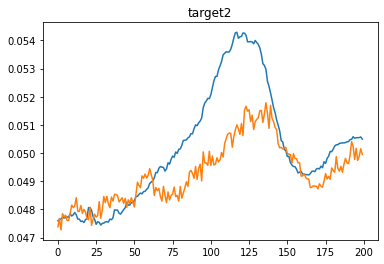

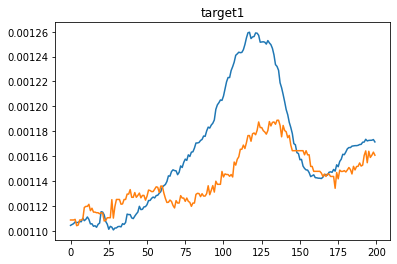

In [209]:
for i in range(1,5):
    plt.figure()
    plt.plot(df.iloc[-50000:, -i].values[:200])
    plt.plot(preds[i-1][:200])
    plt.title(df.columns[-i])

We can see that Gradient Bosting don't work properly even with feature subsampling and model tuning (I did not include these experiments in the final notebook)

<b> Let's try neural networks </b>

First of all, drop all columns with high amount of NaN, so NN don't deal with NaNs

In [4]:
for col in df.columns:
    if df[col].count() < 190000:
        df = df.drop(col, axis = 1)

Fill in NaNs using existing values for avoiding data leakage

In [5]:
df = df.interpolate(method = 'pad')

Explore target variables

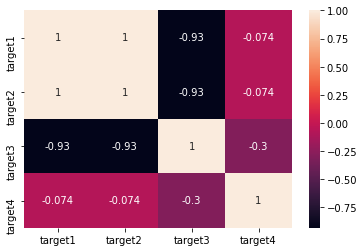

In [210]:
plt.figure()
hm = sns.heatmap(df.iloc[:, -4:].corr(), cbar = True, annot = True)

Interesting moment with target variables its line by line sum up to 1, that mean that we can use sigmoid activation and it's should work well

In [211]:
(df['target1'] + df['target2'] +df['target3'] +df['target4']).unique()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Prepare data

In [163]:
test = 15000
val = 15000

df = df.dropna()

X_train, X_val, X_test =df.iloc[:-(test+val), 1:-4].values, df.iloc[-(test+val):-val, 1:-4].values, df.iloc[-test:, 1:-4].values
y_train, y_val, y_test = df.iloc[:-(test+val), -4:].values,df.iloc[-(test+val):-val, -4:].values, df.iloc[-test:, -4:].values

transformer = StandardScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
X_val = transformer.transform(X_val)

Describe model

In [181]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_chkp.h5', monitor="val_loss", mode='min', verbose = 0, save_best_only=True) 

inp = Input(shape=(48,))
x = Dense(512 ,kernel_regularizer=tf.keras.regularizers.l2(0.05))(inp) #kernel_regularizer=tf.keras.regularizers.l2(0.01)
out = Dense(4, activation= 'sigmoid')(x)
model = Model(inputs=[inp], outputs=out)
model.compile(loss='mae',
              optimizer='nadam',
              metrics=['mse'])

In [182]:
model_hist = model.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val), callbacks = [checkpointer])

Epoch 1/30
5111/5111 [==============================] - 13s 3ms/step - loss: 0.1959 - mse: 0.0094 - val_loss: 0.0037 - val_mse: 2.4725e-05
Epoch 2/30
5111/5111 [==============================] - 13s 2ms/step - loss: 0.0018 - mse: 5.8529e-06 - val_loss: 0.0021 - val_mse: 6.6704e-06
Epoch 3/30
5111/5111 [==============================] - 13s 3ms/step - loss: 0.0014 - mse: 3.7339e-06 - val_loss: 0.0013 - val_mse: 2.1705e-06
Epoch 4/30
5111/5111 [==============================] - 13s 2ms/step - loss: 0.0012 - mse: 3.1100e-06 - val_loss: 0.0014 - val_mse: 2.9692e-06
Epoch 5/30
5111/5111 [==============================] - 13s 2ms/step - loss: 0.0012 - mse: 3.2989e-06 - val_loss: 0.0012 - val_mse: 1.7294e-06
Epoch 6/30
5111/5111 [==============================] - 13s 2ms/step - loss: 0.0011 - mse: 2.9076e-06 - val_loss: 0.0012 - val_mse: 1.9800e-06
Epoch 7/30
5111/5111 [==============================] - 13s 2ms/step - loss: 0.0010 - mse: 3.5231e-06 - val_loss: 0.0015 - val_mse: 2.5766e-06
Epo

load weights of best model

In [184]:
model.load_weights('model_chkp.h5')

Evaluate results

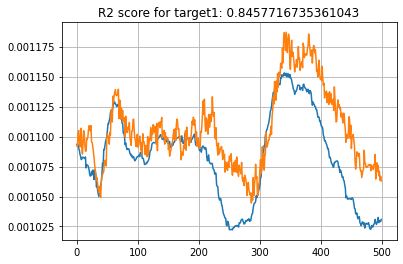

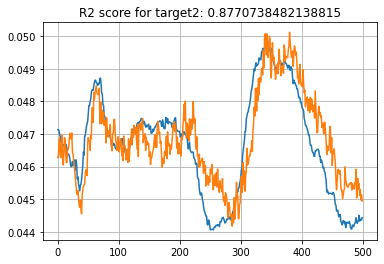

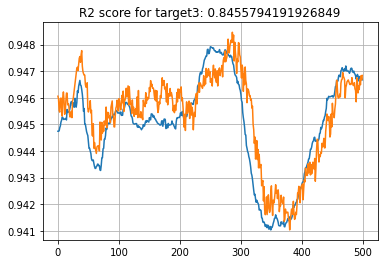

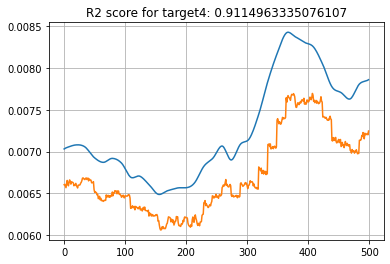

In [212]:
preds = model.predict(X_test)

for i in range(4):
    plt.figure()
    plt.plot(y_test[:500,i])
    plt.plot(preds[:500,i])
    plt.title('R2 score for {}: {}'.format(df.columns[-4+i], r2_score(y_test[:,i], preds[:,i])))
    plt.grid()
    

In [187]:
df_test = pd.read_csv('/content/test_data_100k.csv')

In [189]:
df_test = df_test.loc[:, df.columns[:-4]]
X = transformer.transform(df_test.iloc[:,1:].values)
result = model.predict(X)
out_df = pd.DataFrame(result, columns = df.columns[-4:])
out_df.to_csv('result.csv')